In [2]:
!git clone https://github.com/Latortuga13/CSE151Diabetes.git

Cloning into 'CSE151Diabetes'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 113 (delta 63), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 32.26 MiB | 18.40 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [4]:
from re import A
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#accessing our data
data = pd.read_excel("CSE151Diabetes/Patients Data ( Used for Heart Disease Prediction ).xlsx")


In [5]:
# There is no missing data in our dataset
data.isnull().sum()

# dropping columns we discussed in the README.
data_clean = data.drop(columns=["PatientID", 'HeightInMeters', "WeightInKilograms", "State", "SmokerStatus", "ECigaretteUsage", "TetanusLast10Tdap"])
dSample = data_clean.sample(frac=0.01, random_state=42, axis=0)
dSample.info()

#cleaning our data
data_clean["AgeCategory"] = data["AgeCategory"].str.extract(r"(\d+)")
data_clean["AgeCategory"] = data_clean["AgeCategory"].astype(int)

data_clean = pd.get_dummies(data_clean, columns=['RaceEthnicityCategory'])

health_mapping = {
    "Excellent": 5,
    "Very good": 4,
    "Good": 3,
    "Fair": 2,
    "Poor": 1
}
data_clean["GeneralHealth"] = data_clean["GeneralHealth"].map(health_mapping)
data_clean["GeneralHealth"] = data_clean["GeneralHealth"].astype(int)

sex_mapping = {
    "Male": 1,
    "Female": 0
}

data_clean["Sex"] = data_clean["Sex"].map(sex_mapping)
data_clean["Sex"] = data_clean["Sex"].astype(int)

data_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2376 entries, 39973 to 32459
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sex                        2376 non-null   object 
 1   GeneralHealth              2376 non-null   object 
 2   AgeCategory                2376 non-null   object 
 3   BMI                        2376 non-null   float64
 4   HadHeartAttack             2376 non-null   int64  
 5   HadAngina                  2376 non-null   int64  
 6   HadStroke                  2376 non-null   int64  
 7   HadAsthma                  2376 non-null   int64  
 8   HadSkinCancer              2376 non-null   int64  
 9   HadCOPD                    2376 non-null   int64  
 10  HadDepressiveDisorder      2376 non-null   int64  
 11  HadKidneyDisease           2376 non-null   int64  
 12  HadArthritis               2376 non-null   int64  
 13  HadDiabetes                2376 non-null   objec

,Sex,GeneralHealth,AgeCategory,BMI,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic"
0,0,2,75,32.099998,0,1,0,1,1,0,...,0,0,1,0,1,False,False,False,False,True
1,0,4,65,27.990000,0,0,0,0,0,0,...,0,1,1,0,0,False,False,False,False,True
2,1,5,60,22.530001,0,0,0,0,0,0,...,0,0,0,0,0,False,False,False,False,True
3,1,4,70,30.129999,0,0,0,0,0,0,...,0,1,1,0,0,False,False,False,False,True
4,0,3,50,27.760000,0,0,0,0,0,0,...,0,1,0,0,0,True,False,False,False,False


In [6]:
#Scaled the data to make it easier to compare the weights generated from our model for each feature afterwards.
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

age = pd.DataFrame(data_clean, columns=['AgeCategory'])
age = min_max_scaler.fit_transform(age)
data_clean['AgeCategory'] = age

bmi = pd.DataFrame(data_clean, columns=['BMI'])
bmi = min_max_scaler.fit_transform(bmi)
data_clean['BMI'] = bmi
data_clean.head()

,Sex,GeneralHealth,AgeCategory,BMI,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic"
0,0,2,0.919355,0.234497,0,1,0,1,1,0,...,0,0,1,0,1,False,False,False,False,True
1,0,4,0.758065,0.186500,0,0,0,0,0,0,...,0,1,1,0,0,False,False,False,False,True
2,1,5,0.677419,0.122737,0,0,0,0,0,0,...,0,0,0,0,0,False,False,False,False,True
3,1,4,0.838710,0.211491,0,0,0,0,0,0,...,0,1,1,0,0,False,False,False,False,True
4,0,3,0.516129,0.183814,0,0,0,0,0,0,...,0,1,0,0,0,True,False,False,False,False


In [7]:
from sklearn.preprocessing import StandardScaler
#running of cleaned HadDiabetes Column along with a model using only the test data
data_clean = data_clean[data_clean["HadDiabetes"] != "Yes, but only during pregnancy (female)"]
data_clean = data_clean[data_clean["HadDiabetes"] != "No, pre-diabetes or borderline diabetes"]

X = data_clean.drop("HadDiabetes", axis=1)
Y = data_clean['HadDiabetes']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_encoded,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=0)

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8629 - loss: 0.3175
Test Loss: 0.3182, Test Accuracy: 0.8630
721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

          No       0.87      0.99      0.93     19746
         Yes       0.64      0.10      0.17      3306

    accuracy                           0.86     23052
   macro avg       0.76      0.54      0.55     23052
weighted avg       0.84      0.86      0.82     23052



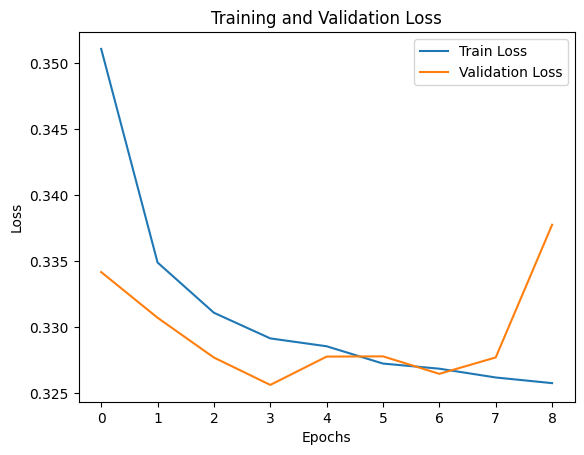

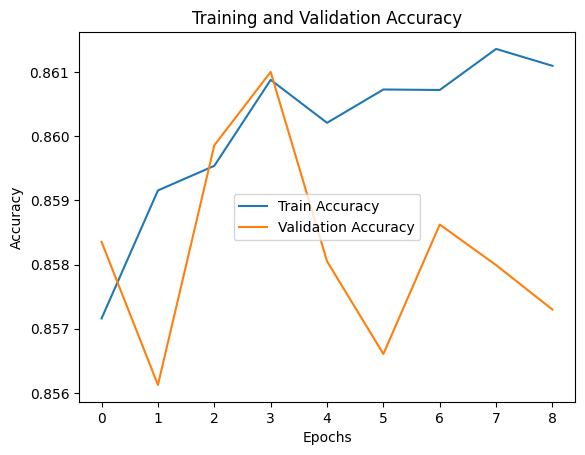

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [28]:
print(X.info())
print(Y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 230518 entries, 0 to 237628
Data columns (total 31 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Sex                                                  230518 non-null  int64  
 1   GeneralHealth                                        230518 non-null  int64  
 2   AgeCategory                                          230518 non-null  float64
 3   BMI                                                  230518 non-null  float64
 4   HadHeartAttack                                       230518 non-null  int64  
 5   HadAngina                                            230518 non-null  int64  
 6   HadStroke                                            230518 non-null  int64  
 7   HadAsthma                                            230518 non-null  int64  
 8   HadSkinCancer                                        230518

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

def build_hp_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    model.add(Dense(
        units=hp.Int('units_layer1', min_value=16, max_value=112, step=32),
        activation=hp.Choice('activation_layer1', values=['relu', 'sigmoid', 'tanh'])
    ))

    model.add(Dense(
        units=hp.Int('units_layer2', min_value=16, max_value=112, step=32),
        activation=hp.Choice('activation_layer2', values=['relu', 'sigmoid', 'tanh'])
    ))

    model.add(Dense(
        units=hp.Int('units_layer3', min_value=16, max_value=112, step=32),
        activation=hp.Choice('activation_layer3', values=['relu', 'sigmoid', 'tanh'])
    ))

    output_units = 1 if len(set(y_train)) == 2 else len(set(y_train))
    output_activation = 'sigmoid' if output_units == 1 else 'softmax'
    loss_function = 'binary_crossentropy' if output_units == 1 else 'categorical_crossentropy'

    model.add(Dense(output_units, activation=output_activation))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.1])),
        loss=loss_function,
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    hypermodel=build_hp_model,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=3,
    directory='my_tuning',
    project_name='tuning_example'
)

tuner.search(X_train_scaled, y_train, epochs=2, validation_data=(X_val_scaled, y_val), verbose=0)

tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Units Layer 1: {best_hps.get('units_layer1')}")
print(f"Units Layer 2: {best_hps.get('units_layer2')}")
print(f"Units Layer 3: {best_hps.get('units_layer3')}")
print(f"Activation Layer 1: {best_hps.get('activation_layer1')}")
print(f"Activation Layer 2: {best_hps.get('activation_layer2')}")
print(f"Activation Layer 3: {best_hps.get('activation_layer3')}")
print(f"Output Activation: {best_hps.get('output_activation')}")
print(f"Loss Function: {best_hps.get('loss')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), verbose=0)

test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

best_model.summary()


Reloading Tuner from my_tuning/tuning_example/tuner0.json
Results summary
Results in my_tuning/tuning_example
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units_layer1: 16
activation_layer1: tanh
units_layer2: 112
activation_layer2: relu
units_layer3: 80
activation_layer3: tanh
output_activation: sigmoid
learning_rate: 0.001
loss: categorical_crossentropy
Score: 0.8628556728363037

Trial 04 summary
Hyperparameters:
units_layer1: 112
activation_layer1: relu
units_layer2: 48
activation_layer2: sigmoid
units_layer3: 16
activation_layer3: sigmoid
output_activation: sigmoid
learning_rate: 0.001
loss: categorical_crossentropy
Score: 0.8627432187398275

Trial 05 summary
Hyperparameters:
units_layer1: 16
activation_layer1: sigmoid
units_layer2: 16
activation_layer2: relu
units_layer3: 16
activation_layer3: sigmoid
output_activation: sigmoid
learning_rate: 0.01
loss: categorical_crossentropy
Score: 0.8619639674822489

Trial 02 summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 16)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 112)                 │           1,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 80)                  │           9,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,613 (135.21 KB)

 Trainable params: 11,537 (45.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,076 (90.14 KB)

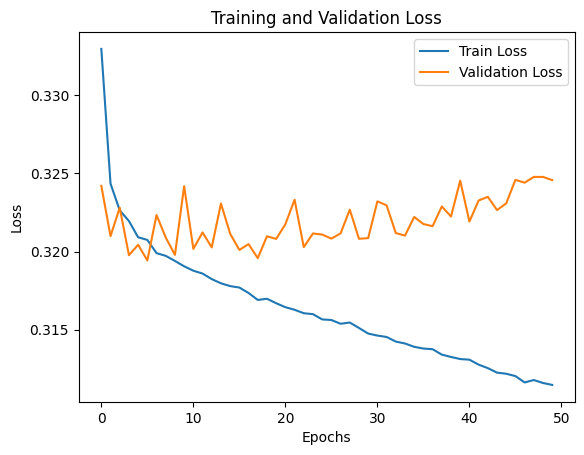

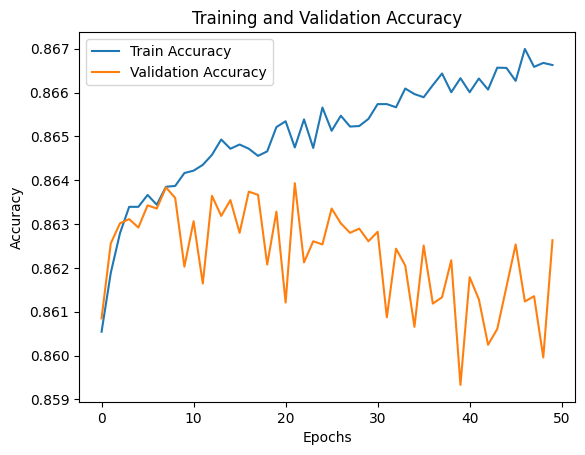

In [30]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()